In [1]:
import os

import joblib


def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from pickle import dump
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skopt import gp_minimize

In [2]:
folders = ['vm/3high-3low/0iid', 'vm/3high-3low/100iid',
           'vm/5high-5low/0iid', 'vm/5high-5low/100iid',
           'vm/10high-10low/0iid', 'vm/10high-10low/100iid',
           'vm/4high-2low/0iid', 'vm/4high-2low/100iid',
           'vm/8high-4low/0iid', 'vm/8high-4low/100iid',
           'vm/2high-4low/0iid', 'vm/2high-4low/100iid',
           'vm/4high-8low/0iid', 'vm/4high-8low/100iid',
           'vm/2high-8low/0iid', 'vm/2high-8low/100iid']
exp_data: pd.DataFrame = pd.DataFrame()

for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        if 'always-selector' in exp_path:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df = df[df['Val F1'] >= 0]
            df['N. Clients'] = df.apply(lambda x: x['Client ID'].split('Client ')[1].split('\n')[0], axis=1)
            last_client = [int(x) for x in df['N. Clients'].unique()]
            df['High-Spec Clients'] = int(folder.split('/')[1].split('high-')[0])
            df['Low-Spec Clients'] = int(folder.split('/')[1].split('high-')[1].split('low')[0])
            df['Previous Val F1'] = df.shift(1)['Val F1']
            df['Previous F1/Time'] = df.shift(1)['F1/Time']
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])
            df = df[df['FL Round'] > 1]
            df['Selector'] = df['N. Clients'].apply(lambda n: int(n) == min(last_client))
            df = df[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round', 'Selector',
                     'Total Time of FL Round', 'Previous F1/Time', 'Previous Val F1', 'F1/Time', 'Val F1']]
            exp_data = pd.concat([exp_data, df])

print(exp_data)

    High-Spec Clients  Low-Spec Clients  IID Data  FL Round  Selector  \
5                   3                 3         0         2      True   
8                   3                 3         0         3      True   
11                  3                 3         0         4      True   
17                  3                 3         0         5     False   
20                  3                 3         0         6      True   
..                ...               ...       ...       ...       ...   
87                  2                 8       100        16      True   
89                  2                 8       100        17      True   
91                  2                 8       100        18      True   
93                  2                 8       100        19      True   
95                  2                 8       100        20      True   

    Total Time of FL Round  Previous F1/Time  Previous Val F1   F1/Time  \
5                    54.75          0.001362    

In [3]:
x = exp_data[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Selector', 'Previous F1/Time']]
y = exp_data[['F1/Time']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8215)

tree_f1overtime = DecisionTreeRegressor(max_depth=5)
tree_f1overtime.fit(x_train, y_train)

print(tree_f1overtime.score(x_train, y_train))
print(tree_f1overtime.score(x_test, y_test))

with open("../predictors/f1overtime_tree_regressor_{}.pkl".format(len(x_train)), "wb") as f:
    dump(tree_f1overtime, f, protocol=5)

0.9020545851255316
0.8919540212216488


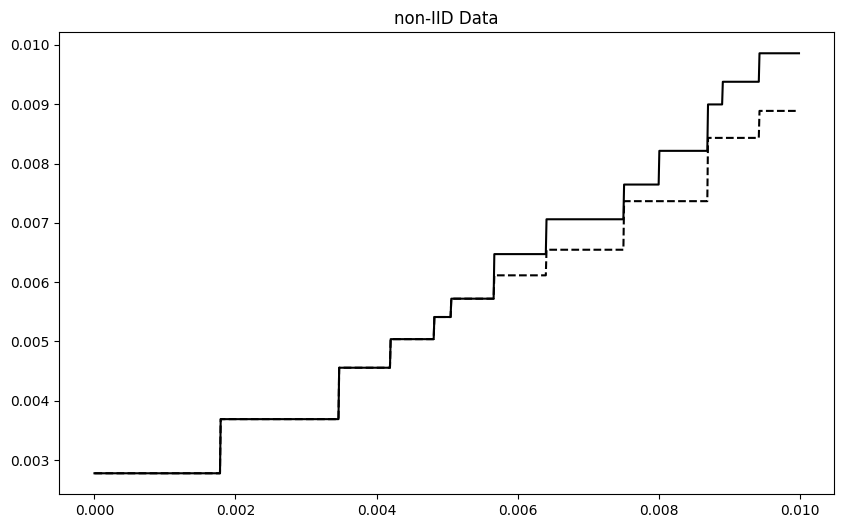

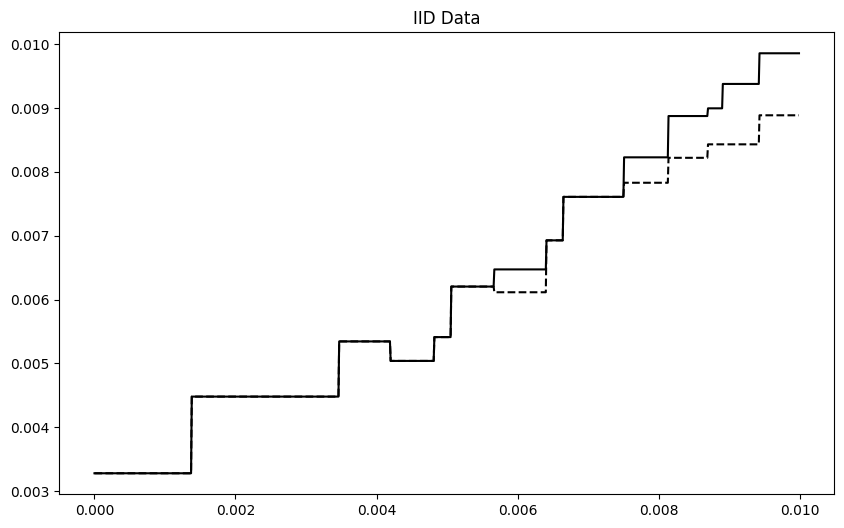

In [4]:
N_high = 5
N_low = 5

x = np.arange(0, 0.01, 0.00001)

plt.figure(figsize=(10, 6))

plt.plot(x, [tree_f1overtime.predict([[N_high, N_low, 0, True, v]])[0] for v in x], color="black")
plt.plot(x, [tree_f1overtime.predict([[N_high, N_low, 0, False, v]])[0] for v in x], '--', color="black")

plt.title('non-IID Data')

plt.show()

plt.figure(figsize=(10, 6))

plt.plot(x, [tree_f1overtime.predict([[N_high, N_low, 100, True, v]])[0] for v in x], color="black")
plt.plot(x, [tree_f1overtime.predict([[N_high, N_low, 100, False, v]])[0] for v in x], '--', color="black")

plt.title('IID Data')

plt.show()

In [15]:
# Features and target
x = exp_data[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Selector', 'FL Round', 'Previous F1/Time']]
y = exp_data['F1/Time']

# Standardize input (important for GPR)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Define GPR with RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=42)

# Fit model
# WARNING!! Takes approx. 1 min to complete
gpr.fit(X_train, y_train)

joblib.dump(gpr, '../predictors/bo_model.pkl')
joblib.dump(scaler, '../predictors/bo_scaler.pkl')

# Predict on test set
y_pred, sigma = gpr.predict(X_test, return_std=True)

# Output example
for xi, pred, std in zip(X_test, y_pred, sigma):
    print(f"Input: {scaler.inverse_transform([xi])[0]} → Predicted accuracy: {pred:.3f} ± {std:.3f}")

Input: [5.00000000e+00 5.00000000e+00 1.00000000e+02 1.00000000e+00
 1.30000000e+01 5.85012087e-03] → Predicted accuracy: 0.008 ± 0.055
Input: [5.00000000e+00 5.00000000e+00 1.00000000e+02 1.00000000e+00
 7.00000000e+00 5.30987514e-03] → Predicted accuracy: 0.006 ± 0.023
Input: [5.00000000e+00 5.00000000e+00 1.00000000e+02 0.00000000e+00
 1.20000000e+01 9.80651909e-03] → Predicted accuracy: 0.008 ± 0.056
Input: [2.00000000e+00 4.00000000e+00 0.00000000e+00 1.00000000e+00
 1.80000000e+01 8.07842408e-03] → Predicted accuracy: 0.056 ± 0.048
Input: [8.00000000e+00 4.00000000e+00 0.00000000e+00 1.00000000e+00
 1.30000000e+01 5.25608953e-03] → Predicted accuracy: 0.014 ± 0.029
Input: [5.00000000e+00 5.00000000e+00 1.00000000e+02 1.00000000e+00
 1.30000000e+01 8.92103472e-03] → Predicted accuracy: 0.009 ± 0.001
Input: [4.0000000e+00 2.0000000e+00 1.0000000e+02 0.0000000e+00 3.0000000e+00
 5.8434061e-03] → Predicted accuracy: 0.007 ± 0.002
Input: [3.00000000e+00 3.00000000e+00 1.00000000e+02 1

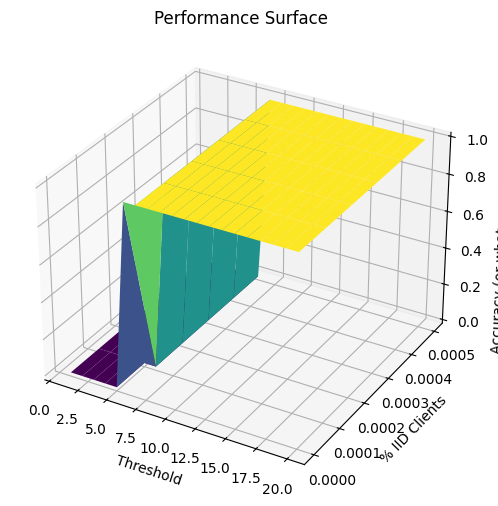

In [17]:
gpr = joblib.load('../predictors/bo_model.pkl')

rounds = np.linspace(1, 20, 20)
f1_over_time = np.arange(0, 0.0006, 0.0001)
X, Y = np.meshgrid(rounds, f1_over_time)


def objective(policy_on, curr_round, prev_f1_overtime):  # binary: 0 or 1
    X = [[2, 8, 0, policy_on[0], curr_round, prev_f1_overtime]]
    X_scaled = scaler.transform(X)
    y_pred = -gpr.predict(X_scaled)[0]  # maximize → minimize negative
    return y_pred


Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        def wrapped_objective(policy_on):
            curr_round = X[i, j]
            prev_f1_overtime = Y[i, j]

            return objective(policy_on, curr_round, prev_f1_overtime)


        res = gp_minimize(wrapped_objective,  # objective fn
                          [(0, 1)],  # policy_on ∈ {0,1}
                          acq_func="EI",  # acquisition function
                          n_calls=10, random_state=42)

        Z[i, j] = res.x[0]

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Threshold')
ax.set_ylabel('% IID Clients')
ax.set_zlabel('Accuracy (or whatever your metric is)')
plt.title("Performance Surface")
plt.show()
